# Aplicación de un Modelo de Interacción Espacial a datos departamentales

Datos utilizados como variables independientes:

- La población total en origen y destino
- Totales de personas que declaran haber vivido antes en el departamento de origen
- Distancias y logaritmo de la distancia entre centros medios de población
- Dummy de límites compartidos
- Largo del límite compartido
- El PBI en el departamento de destino y el logaritmo de dicho valor

In [41]:
import pandas as pd
import geopandas as gpd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pylab as pl
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import r2_score, mean_squared_error
import tabulate
from operator import add
from shapely import wkt
from shapely.geometry import shape, LineString, Point

from functions.cargar_data import cargar_datos_geo, cargar_migrantes_internos, \
    recuperar_poblacion_2011, cargar_dd_deptos, cargar_nombres
from functions.impresion import printmath, printmd
from functions.geograficas import odflow
from functions.graficas import size_font, save_chart, hide_spines
from functions.modelos import print_scores, get_gml_params, print_params

size, font, font_legend = size_font()

In [42]:
# carga capas de datos geográficos
deptos, deptos_sim, localidad, centro_pobl, capital = cargar_datos_geo()

# carga migrantes internos
p_migr = cargar_migrantes_internos()

# carga poblacion por depto
pobl = recuperar_poblacion_2011()

# carga datos diádicos
dd_deptos = cargar_dd_deptos()
dd_deptos.head(3)

,cod,depto_origen,depto_destino,personas_mig,personas_mig_18_25,personas_mig_26_35,personas_mig_100k,pob_origen,pob_destino,dist,...,tasa_desemp_total_2011_des,log_pbi_destino,log_dist_km,log_pbi_origen_millardos,log_pbi_destino_millardos,log_pob_destino_k,log_pob_origen_k,log_edad_prom_des,log_porc_ocupados_des,largo_limite_km
0,102,1,2,914,114,247,891,1318755,73377,610726,...,8.1,16.469807,6.415097,6.143859,2.654298,4.295611,7.184443,3.525387,4.151677,1.000000e-07
1,302,3,2,74,9,22,70,520173,73377,601915,...,8.1,16.469807,6.400257,4.457899,2.654298,4.295611,6.254161,3.525387,4.151677,1.000000e-07
2,402,4,2,15,0,6,14,84698,73377,406694,...,8.1,16.469807,6.008813,2.836092,2.654298,4.295611,4.439092,3.525387,4.151677,1.000000e-07


Dada la menor complejidad, se comienza por el análisis de los flujos entre departamentos.
La base de personas del Censo INE 2011 se filtra según el siguiente criterio:
- Variable "PERMI07" (lugar de residencia 5 años antes) con valores:
    - 2 = en otra localidad o paraje de este departamento
    - 3 = en otro departamento
    
Se excluyen habitantes de localidades rurales.

La tabla resultante contiene un departamento de origen, uno de destino y una cantidad de personas que declaran haber vivido antes en el departamento de "origen", habiendo sido relevadas en el departamento de "destino" al momento de la aplicación del formulario censal.


### El perfil de la migración interna

Algunas características de la población migrante interna:

- el perfil más joven y feminizado de quienes migran hacia Montevideo.

- el perfil de familias completas, integradas por parejas de entre 30 y 40 años con niños, de quienes migran desde Montevideo.

In [43]:
# genera un sólo dataframe solo para deptos
flujos_deptos = p_migr[['depto_origen', 'depto_destino']]

flujos_deptos = flujos_deptos[flujos_deptos.depto_origen != flujos_deptos.depto_destino]

flujos_deptos['personas_mig'] = 1

# agrupa y cuenta
grupo = flujos_deptos.groupby(by=['depto_origen', 'depto_destino']).sum()

print('Cantidad de díadas ', grupo.shape[0])

# genera tabla pivot con los flujos de departamento a departamento
matrix = pd.pivot_table(flujos_deptos,
                        index ='depto_origen',
                        columns='depto_destino',
                        fill_value=0,
                        aggfunc=sum,
                        margins=True,
                        margins_name='Total')
matrix

Cantidad de díadas  342


personas_mig                                                   \
depto_destino            1     2      3     4     5     6     7     8     9   
depto_origen                                                                  
1                        0   914  33127  1387  2100   982   378  1026   825   
2                     2395     0    536    20   167    33    21    40    15   
3                    11162    74      0   274   422   223    82   670   403   
4                     1805    15    435     0    63    67     5    73   131   
5                     2690    28    366    20     0    63    69    53    19   
6                     1610    32    466    64    70     0   149   404    67   
7                      735     2    162    13    86    90     0    76     5   
8                     1420    13    892    37   107   307    84     0   163   
9                     1264     7    446    64    39    29    17   138     0   
10                    2333    46    862   208   196    75    58   121   407   
11                    2096    75    434    35   151    55    29    57    37   
12                    1219    30    316    20   176    54    77    27    15   
13                    2390   102    584   162    77    50    22    63    49   
14                    1435     8    407    59    49    18     7    45   130   
15                    2481   380    543    18   134    14    20    48    20   
16                    1852    15    689    31   452    59   122   252    44   
17                    1922     9    293    12  1053    57    90    40    33   
18                    2611    50    596   168    79   304    79    92    50   
19                    1024    10    259   409    41    91     2    58   172   
Total                42444  1810  41413  3001  5462  2571  1311  3283  2585   

                                                                            \
depto_destino     10    11    12    13    14    15    16    17    18    19   
depto_origen                                                                 
1               3914  1075   886  1665  1266  1547  4209  1173  1421   760   
2                472   200    57   146    47   794    92    24   100     5   
3               1345   148   154   320   360   159   908   154   251   124   
4                810    61    41   145    95    19    49    34   135   476   
5                309    71    88    34    35    68   269   513    34    23   
6                198    59    62    42    61    28   124    32   212    77   
7                 79    30    36    10    13    17   116    85    29    14   
8                310    47    30    46    62    19   321    51    68    64   
9                936    28    11    25   150    15    45    11    45   221   
10                 0    95    95   117   535    98   131   110    71   259   
11               420     0   640    66    50   480   116    98   229    25   
12               223   516     0    54    48   133   107   270    89     9   
13               227   143    36     0    46   120    99    25   546    57   
14               952    32    30    17     0    29    45    18    21   162   
15               484   564   161    97    38     0    99    75   166     8   
16               230    59    55    32    47    30     0   112    53    23   
17               335   181   372    18    46    98   147     0    41    16   
18               363   261   134   421    35   174    88    72     0    32   
19               776    16    16    23   174    13    28    25    38     0   
Total          12383  3586  2904  3278  3108  3841  6993  2882  3549  2355   

                       
depto_destino   Total  
depto_origen           
1               58655  
2                5164  
3               17233  
4                4459  
5                4752  
6                3757  
7                1598  
8                4041  
9                3491  
10               5817  
11               5093  
12               3383  
13               4798  
14               

In [44]:
# función para hacer lineas a partir de códigos origen-destino y una geografía conocida
# https://github.com/danlewis85/UCL_CASA_Urban_Simulation/blob/master/Unconstrained%20Spatial%20Interaction%20Models.ipynb

# aplica dd_deptos
flows = odflow(dd_deptos, 'depto_origen', 'depto_destino', 'personas_mig', deptos, 'cod_ine')

# guarda como geopaquete
# flows.to_file("capas/deptos_mig_recientes_2011.gpkg", layer='flujos', driver="GPKG")

c:\Users\59898\anaconda3\envs\tesis\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


In [45]:
# guarda para webmap
cols_links = ['depto_destino', 'depto_origen','personas_mig']
links = pd.DataFrame(flows[cols_links])
links.columns = ['target', 'source', 'flows']
# links.to_csv('webmap_flows/data/links.csv', index= False)

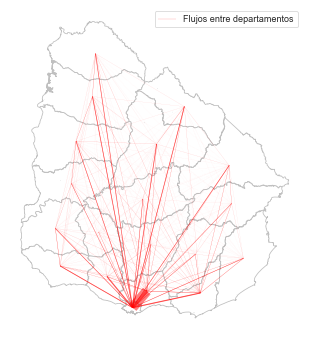

In [46]:
# plot de flujos
f, ax = plt.subplots(1,figsize=(8,6))

# apaga ejes
plt.axis('off')
ax.get_yaxis().set_visible(False)
ax.get_xaxis().set_visible(False)

# capa de departamentos
deptos.plot(color='w', edgecolor='silver' ,ax=ax)

# máximo de flujos para escalado
maxflow = float(max(flows['personas_mig']))

# título
# pl.title("Representación gráfica de las migraciones recientes", size=10)

# plotea flows, calcula ancha de línea con una función sobre 'personas_mig'
flows.plot(linewidth = flows.apply(lambda x: (x['personas_mig']/maxflow)*10, axis=1),
           color= 'red',
           ax=ax,
           label='Flujos entre departamentos',
           alpha=0.5)

ax.set_aspect('equal')

# referencias
plt.legend(fontsize=9)

metadatos_figs = {'Author': '''Guillermo D'Angelo'''}

# plt.savefig('mapas_graficas/links_depto.pdf',
#            bbox_inches='tight',
#            metadata = metadatos_figs )

## Gráficas de distancia

#### Totales

Se guardó la gráfica en mapas_graficas/modelos_flujos_vs_distancia.pdf


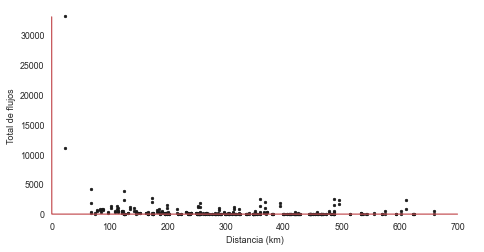

In [47]:
sns.set(font="Arial")

sns.set_context("paper", rc={"font.size":size,
                             "axes.titlesize":size,
                             "axes.labelsize":size})   

sns.set_style("white")

# Gráfico de flujos contra distancia
f, ax = plt.subplots(1, figsize=(8,4))

# plot de los puntos
ax.scatter(dd_deptos['dist']/1000, dd_deptos['personas_mig'], marker='.', color='k')

# crea la linea roja
xvals = np.geomspace(0.0055, 700, 1000)
yvals = np.power(xvals, -2)

# la agrega al plot
ax.plot(xvals, yvals, color='r')

# hide spines
[ax.spines[i].set_visible(False) for i in ['right', 'top', 'left', 'bottom']]

# etiquetas
ax.set_ylabel("Total de flujos", font='Arial')
ax.set_xlabel("Distancia (km)", font='Arial')

ax.tick_params(axis='x', pad=-6)
ax.tick_params(axis='y', pad=-18)

# se ven dos outlyers claramente, deben ser Mvdeo y Canelones.
save_chart('modelos_flujos_vs_distancia.pdf', metadatos_figs)

#### Sin Montevideo

Se guardó la gráfica en mapas_graficas/modelos_flujos_vs_distancia_sin_MVO.pdf


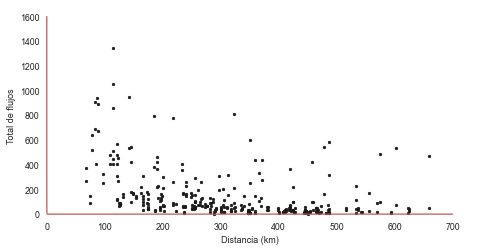

In [48]:
# mismo gráfico sin Mvdeo.
sin_mvo = dd_deptos[(dd_deptos['depto_origen'] > 1) & (dd_deptos['depto_destino'] > 1)]

# Gráfico de flujos contra distancia
f, ax = plt.subplots(1, figsize=(8,4))

# plot de los puntos
ax.scatter(sin_mvo['dist']/1000, sin_mvo['personas_mig'], marker='.', color='k')

# crea la linea roja
xvals = np.geomspace(0.025, 700, 100)
yvals = np.power(xvals, -2)

# la agrega al plot
ax.plot(xvals, yvals, color='r')

# hide spines
hide_spines(ax, todos=True)

# Etiquetas
ax.set_ylabel("Total de flujos")
ax.set_xlabel("Distancia (km)")

ax.tick_params(axis='x', pad=-6)
ax.tick_params(axis='y', pad=-18)

save_chart('modelos_flujos_vs_distancia_sin_MVO.pdf', metadatos_figs)

Se guardó la gráfica en mapas_graficas/modelos_flujos_vs_pob_origen.pdf


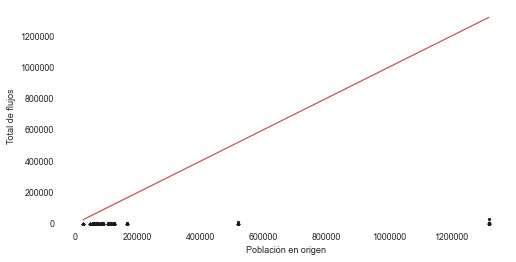

In [49]:
# gráfico de flujos contra población en el origen
f, ax = plt.subplots(1, figsize=(8,4))

# Plot data points
ax.scatter(dd_deptos['pob_origen'], dd_deptos['personas_mig'], marker='.', color='k')

xvals = np.linspace(dd_deptos['pob_origen'].min(), dd_deptos['pob_origen'].max(), 100)
yvals = np.power(xvals, 1.0)

# Now add function line to plot
ax.plot(xvals, yvals, color='r')

# need to set the ylim to the domain of the origin pops, so we see the full line.
ax.set_ylim(-5000, dd_deptos['pob_origen'].max()*1.05)

# hide spines
hide_spines(ax, todos=True)

# Add some labels
ax.set_ylabel("Total de flujos")
ax.set_xlabel("Población en origen")

plt.ticklabel_format(style='plain')

save_chart('modelos_flujos_vs_pob_origen.pdf', metadatos_figs)

Se guardó la gráfica en mapas_graficas/modelos_flujos_vs_pob_origen_sin_MVO.pdf


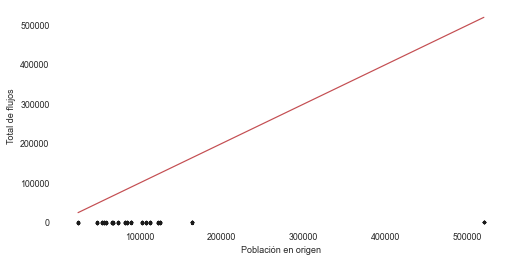

In [50]:
# gráfico de flujos contra población en el origen
f, ax = plt.subplots(1, figsize=(8,4))

# Plot data points
ax.scatter(sin_mvo['pob_origen'], sin_mvo['personas_mig'], marker='.', color='k')

xvals = np.linspace(sin_mvo['pob_origen'].min(), sin_mvo['pob_origen'].max(), 100)
yvals = np.power(xvals, 1.0)

# Now add function line to plot
ax.plot(xvals,yvals,color='r')

# need to set the ylim to the domain of the origin pops, so we see the full line.
ax.set_ylim(-5000, sin_mvo['pob_origen'].max()*1.05)

# hide spines
hide_spines(ax, todos=True)

# Add some labels
ax.set_ylabel("Total de flujos")
ax.set_xlabel("Población en origen")

save_chart('modelos_flujos_vs_pob_origen_sin_MVO.pdf', metadatos_figs)

Se guardó la gráfica en mapas_graficas/modelos_flujos_vs_pbi_destino.pdf


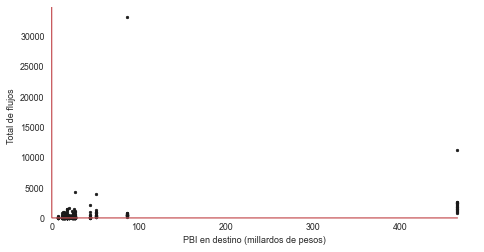

In [51]:
# Plot de PBI en destino contra personas migrantes
f, ax = plt.subplots(1, figsize=(8,4))

# Plot data points
ax.scatter(dd_deptos['pbi_destino_millardos'], dd_deptos['personas_mig'], marker='.',color='k')

# crea la linea roja
xvals = np.geomspace(0.005, max(dd_deptos['pbi_destino_millardos']), 500)
yvals = np.power(xvals, -2.0)
ax.plot(xvals, yvals, color='r')

# need to set the ylim to the domain of the origin pops, so we see the full line.
ax.set_ylim(-1000, dd_deptos['personas_mig'].max()*1.05)

# hide spines
hide_spines(ax, todos=True)

ax.tick_params(axis='x', pad=-6)
ax.tick_params(axis='y', pad=-18)

# Add some labels
ax.set_ylabel("Total de flujos")
ax.set_xlabel("PBI en destino (millardos de pesos)")



save_chart('modelos_flujos_vs_pbi_destino.pdf', metadatos_figs)

Se guardó la gráfica en mapas_graficas/modelos_flujos_vs_pbi_destino_sin_MVO.pdf


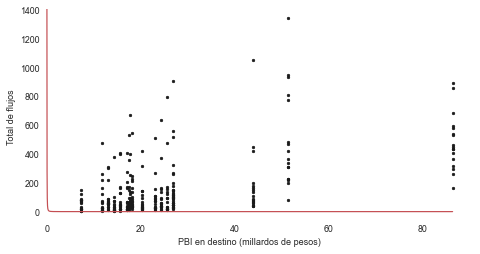

In [52]:
# Plot de PBI en destino contra personas migrantes
# Plot de PBI en destino contra personas migrantes
f, ax = plt.subplots(1, figsize=(8,4))

# Plot data points
ax.scatter(sin_mvo['pbi_destino_millardos'], sin_mvo['personas_mig'], marker='.',color='k')

# crea la linea roja
xvals = np.geomspace(0.000000001, max(sin_mvo['pbi_destino_millardos']), 500000)
yvals = np.power(xvals, -2.0)
ax.plot(xvals, yvals, color='r')

# need to set the ylim to the domain of the origin pops, so we see the full line.
ax.set_ylim(-100, sin_mvo['personas_mig'].max()*1.05)

# hide spines
hide_spines(ax, todos=True)

ax.tick_params(axis='x', pad=-6)
ax.tick_params(axis='y', pad=-18)

# Add some labels
ax.set_ylabel("Total de flujos")
ax.set_xlabel("PBI en destino (millardos de pesos)")

save_chart('modelos_flujos_vs_pbi_destino_sin_MVO.pdf', metadatos_figs)

In [53]:
dd_deptos.head()

,cod,depto_origen,depto_destino,personas_mig,personas_mig_18_25,personas_mig_26_35,personas_mig_100k,pob_origen,pob_destino,dist,...,tasa_desemp_total_2011_des,log_pbi_destino,log_dist_km,log_pbi_origen_millardos,log_pbi_destino_millardos,log_pob_destino_k,log_pob_origen_k,log_edad_prom_des,log_porc_ocupados_des,largo_limite_km
0,102,1,2,914,114,247,891,1318755,73377,610726,...,8.1,16.469807,6.415097,6.143859,2.654298,4.295611,7.184443,3.525387,4.151677,1.000000e-07
1,302,3,2,74,9,22,70,520173,73377,601915,...,8.1,16.469807,6.400257,4.457899,2.654298,4.295611,6.254161,3.525387,4.151677,1.000000e-07
2,402,4,2,15,0,6,14,84698,73377,406694,...,8.1,16.469807,6.008813,2.836092,2.654298,4.295611,4.439092,3.525387,4.151677,1.000000e-07
3,502,5,2,28,7,8,25,123203,73377,556292,...,8.1,16.469807,6.320768,3.779383,2.654298,4.295611,4.813833,3.525387,4.151677,1.000000e-07
4,602,6,2,32,0,10,29,57084,73377,446123,...,8.1,16.469807,6.100319,2.566794,2.654298,4.295611,4.044524,3.525387,4.151677,1.000000e-07


## Modelo restringido en origen

1 $$T_{ij} = A_{i}O_{i}W_{j}^{\alpha}d_{ij}^{-\beta}$$

dónde

2 $$O_{i} = \sum_{j}T_{ij}$$
3 $$A_{i} = \frac{1}{\sum_{j}W_{j}^{\alpha}d_{ij}^{-\beta}}$$

En el modelo restringido en origen $O_{i}$ no tiene parámetro dado que representa valores conocidos. $A_{i}$ es un factor de balance que refiere a cada origen $i$. Más específicamente $A_{i}$ permite que la suma de los valores estimados sea igual al total conocido $O_{i}$

El modelo es re-especificado como un modelo de regresión de Poisson, aplicando el logaritmo, transformando la ecuación 1 en la siguiente:

4   $$ \lambda_{ij} = \exp( \mu_{i} + \alpha \ln W_{j} - \beta \ln d_{ij} )$$


En el modelo re-especificado, $\mu_{i}$ suplanta a $A_{i}O_{i}$.



In [54]:
# carga datos guardados previamente
# respalda el objeto para usarlo en el otro modelo
dd_deptos_ps = cargar_dd_deptos()
dd_deptos_ps.head(3)

,cod,depto_origen,depto_destino,personas_mig,personas_mig_18_25,personas_mig_26_35,personas_mig_100k,pob_origen,pob_destino,dist,...,tasa_desemp_total_2011_des,log_pbi_destino,log_dist_km,log_pbi_origen_millardos,log_pbi_destino_millardos,log_pob_destino_k,log_pob_origen_k,log_edad_prom_des,log_porc_ocupados_des,largo_limite_km
0,102,1,2,914,114,247,891,1318755,73377,610726,...,8.1,16.469807,6.415097,6.143859,2.654298,4.295611,7.184443,3.525387,4.151677,1.000000e-07
1,302,3,2,74,9,22,70,520173,73377,601915,...,8.1,16.469807,6.400257,4.457899,2.654298,4.295611,6.254161,3.525387,4.151677,1.000000e-07
2,402,4,2,15,0,6,14,84698,73377,406694,...,8.1,16.469807,6.008813,2.836092,2.654298,4.295611,4.439092,3.525387,4.151677,1.000000e-07


Especificación del modelo sin intercepto (dado por el valor -1 en la fórmula).

Esto quiere decir que todos lo $A_{i}O_{i}$ son estimados contra in intercepto de 0.

Incluir el intervalo significaría usar el primer departamento en la variable "nom_depto_orig" como intercepto, e interpretar todas las demás categorías con respecto a eso.

In [55]:
dd_deptos_ps.columns

Index(['cod', 'depto_origen', 'depto_destino', 'personas_mig',
       'personas_mig_18_25', 'personas_mig_26_35', 'personas_mig_100k',
       'pob_origen', 'pob_destino', 'dist', 'dist_km', 'pbi_origen',
       'pbi_porcen_ori', 'pbi_destino', 'pbi_porcen_des',
       'pbi_origen_millardos', 'pbi_destino_millardos', 'largo_limite',
       'dummy_limit', 'empresas_origen', 'empresas_destino',
       'menores_25_origen', 'menores_25_destino', 'pob_destino_k',
       'pob_origen_k', 'nom_depto_orig', 'nom_depto_des', 'edad_prom_ori',
       'porc_ocupados_ori', 'edad_prom_des', 'porc_ocupados_des',
       'tasa_desemp_mujeres_2011_ori', 'tasa_desemp_varones_2011_ori',
       'tasa_desemp_total_2011_ori', 'tasa_desemp_mujeres_2011_des',
       'tasa_desemp_varones_2011_des', 'tasa_desemp_total_2011_des',
       'log_pbi_destino', 'log_dist_km', 'log_pbi_origen_millardos',
       'log_pbi_destino_millardos', 'log_pob_destino_k', 'log_pob_origen_k',
       'log_edad_prom_des', 'log_porc_ocup

In [56]:
# define el string tomado como fórmula
formula = "personas_mig ~ nom_depto_orig + log_pbi_destino + log_dist_km -1"

# entrena y ajusta el modelo
prodSim = smf.glm(formula=formula, data=dd_deptos_ps, family = sm.families.Poisson()).fit()

# resultados
prodSim.summary()

# la desviación y el coef de chi cuadrado no son buenas señales
# https://towardsdatascience.com/an-illustrated-guide-to-the-poisson-regression-model-50cccba15958
# https://www.medcalc.org/manual/chi-square-table.php

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:           personas_mig   No. Observations:                  342
Model:                            GLM   Df Residuals:                      321
Model Family:                 Poisson   Df Model:                           20
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -14977.
Date:                Tue, 02 Aug 2022   Deviance:                       27726.
Time:                        18:28:43   Pearson chi2:                 3.00e+04
No. Iterations:                     6   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
nom_depto_orig[ARTIGAS]           -4.5007      0.057    -79.535      0.000      -4.612      -4.390
nom_depto_orig[CANELONES]         -5.0143      0.053    -94.994      0.000      -5.118      -4.911
nom_depto_orig[CERRO LARGO]       -4.8738      0.057    -86.174      0.000      -4.985      -4.763
nom_depto_orig[COLONIA]           -5.2311      0.056    -93.753      0.000      -5.340      -5.122
nom_depto_orig[DURAZNO]           -5.4793      0.056    -97.698      0.000      -5.589      -5.369
nom_depto_orig[FLORES]            -6.4405      0.059   -109.411      0.000      -6.556      -6.325
nom_depto_orig[FLORIDA]           -5.7378      0.056   -103.163      0.000      -5.847      -5.629
nom_depto_orig[LAVALLEJA]         -5.7421      0.056   -102.245      0.000      -5.852      -5.632
nom_depto_orig[MALDONADO]         -5.1720      0.055    -93.391      0.000      -5.281      -5.063
nom_depto_orig[MONTEVIDEO]        -2.8193      0.050    -56.847      0.000      -2.917      -2.722
nom_depto_orig[PAYSANDU]          -4.8903      0.055    -88.124      0.000      -4.999      -4.782
nom_depto_orig[RIO NEGRO]         -5.4065      0.056    -96.322      0.000      -5.517      -5.296
nom_depto_orig[RIVERA]            -4.6868      0.056    -82.969      0.000      -4.798      -4.576
nom_depto_orig[ROCHA]             -5.3493      0.057    -93.929      0.000      -5.461      -5.238
nom_depto_orig[SALTO]             -4.6293      0.056    -82.638      0.000      -4.739      -4.520
nom_depto_orig[SAN JOSE]          -5.8894      0.055   -106.224      0.000      -5.998      -5.781
nom_depto_orig[SORIANO]           -5.1478      0.055    -92.865      0.000      -5.256      -5.039
nom_depto_orig[TACUAREMBO]        -4.7400      0.056    -84.894      0.000      -4.849      -4.631
nom_depto_orig[TREINTA Y TRES]    -5.4158      0.057    -95.078      0.000      -5.527      -5.304
log_pbi_destino                    0.8534      0.002    356.161      0.000       0.849       0.858
log_dist_km                       -0.7889      0.004   -224.754      0.000      -0.796      -0.782
==================================================================================================
"""

In [57]:
# guarda en latex
# prodSim_latex = prodSim.summary().as_latex()
# f = open("tablas/prodSim.tex", "w")
# f.write(prodSim_latex)
# f.close()

In [58]:
# imprime parámetros
variables= ['log_pbi_destino', 'log_dist_km']

params, params_str = get_gml_params(prodSim, variables)

print_params(variables, params_str)

alpha (log_pbi_destino) = 0.8534
beta (log_dist_km) = -0.7889
    


De los resultados se desprende un parámetro $\alpha$ relacionado a la actractividad del destino de **0,8527**.

El parámetro $\beta$ relativo al decaimiento por la distancia es de **-0,7830**.

El coeficiente para cada origen es el valor registrado $A_{i}O_{i}$ para ese origen.

### Estimación del modelo restringido en origen

Los parámetros calculados se insertan en la ecuación presentada anteriormente:

In [59]:
# imprime la ecuación
alpha = params_str[0]
beta =  params_str[1]
ij = '{ij}'

def get_eq_string(alpha, beta):
    eq_str='''\lambda_{2} = \exp( \mu_i + {0} ln W_j  + ({1} ln d_{2}))'''.format(alpha, beta, ij)
    return eq_str

printmath(get_eq_string(alpha, beta))

<IPython.core.display.Math object>

In [60]:
# crea la sumatoria de migrantes en origen (Oi)
O_i = dd_deptos_ps.groupby('depto_origen')['personas_mig'].sum().to_frame().rename(columns = {'personas_mig':'O_i'})

# crea la sumatoria de migrantes en destino (Di)
D_j = dd_deptos_ps.groupby('depto_destino')['personas_mig'].sum().to_frame().rename(columns = {'personas_mig':'D_j'})

# pega ambas variables con el df
dd_deptos_ps = dd_deptos_ps.merge(O_i, left_on='depto_origen', right_index=True)
dd_deptos_ps = dd_deptos_ps.merge(D_j, left_on='depto_destino', right_index=True)

dd_deptos_ps.head()

,cod,depto_origen,depto_destino,personas_mig,personas_mig_18_25,personas_mig_26_35,personas_mig_100k,pob_origen,pob_destino,dist,...,log_dist_km,log_pbi_origen_millardos,log_pbi_destino_millardos,log_pob_destino_k,log_pob_origen_k,log_edad_prom_des,log_porc_ocupados_des,largo_limite_km,O_i,D_j
0,102,1,2,914,114,247,891,1318755,73377,610726,...,6.415097,6.143859,2.654298,4.295611,7.184443,3.525387,4.151677,1.000000e-07,58655,1810
1,302,3,2,74,9,22,70,520173,73377,601915,...,6.400257,4.457899,2.654298,4.295611,6.254161,3.525387,4.151677,1.000000e-07,17233,1810
2,402,4,2,15,0,6,14,84698,73377,406694,...,6.008813,2.836092,2.654298,4.295611,4.439092,3.525387,4.151677,1.000000e-07,4459,1810
3,502,5,2,28,7,8,25,123203,73377,556292,...,6.320768,3.779383,2.654298,4.295611,4.813833,3.525387,4.151677,1.000000e-07,4752,1810
4,602,6,2,32,0,10,29,57084,73377,446123,...,6.100319,2.566794,2.654298,4.295611,4.044524,3.525387,4.151677,1.000000e-07,3757,1810


In [61]:
# recupera los parámetros del modelo
mu_i = prodSim.params.to_frame()

# elimina caractérres no numéricos para poder pegar
mu_i.rename(index = dict(zip(mu_i.index[0:-2].values, mu_i.index[0:-2].str.replace(r'[^ ABCDEFGHIJKLMNÑOPQRSTUVWXYZ]','', regex=True).values)),
            inplace=True)

# renombre columna
mu_i.rename(columns = {0:'mu_i'}, inplace=True)

# merge
dd_deptos_ps = dd_deptos_ps.merge(mu_i, left_on='nom_depto_orig', right_index=True)

dd_deptos_ps.head(3)

,cod,depto_origen,depto_destino,personas_mig,personas_mig_18_25,personas_mig_26_35,personas_mig_100k,pob_origen,pob_destino,dist,...,log_pbi_origen_millardos,log_pbi_destino_millardos,log_pob_destino_k,log_pob_origen_k,log_edad_prom_des,log_porc_ocupados_des,largo_limite_km,O_i,D_j,mu_i
0,102,1,2,914,114,247,891,1318755,73377,610726,...,6.143859,2.654298,4.295611,7.184443,3.525387,4.151677,1.000000e-07,58655,1810,-2.81933
18,103,1,3,33127,3757,7904,0,1318755,520173,22544,...,6.143859,4.457899,6.254161,7.184443,3.566899,4.263316,6.010700e+01,58655,41413,-2.81933
36,104,1,4,1387,162,401,1349,1318755,84698,393703,...,6.143859,2.836092,4.439092,7.184443,3.572760,4.183302,1.000000e-07,58655,3001,-2.81933


In [62]:
# genera estimación redondeada
def prod_sim_est(df, variables, alpha, beta):
    "Estimación del modelo imputando los parámetros alfa y beta previamente calculados"
    prodsimest = np.exp(df['mu_i'] + alpha * df[variables[0]] + beta * df[variables[1]])
    return round(prodsimest)

In [63]:
# recupera alpha y beta, previamente guardados en la lista de parámetros
alpha, beta = [i for i in params]

# estima y guarda en columna "podsimtest"
dd_deptos_ps['prodsimest'] = prod_sim_est(dd_deptos_ps, variables, alpha, beta)
dificil=prod_sim_est(dd_deptos_ps, variables, alpha, beta)

#### La forma fácil, aprovechando *statsmodel*

In [64]:
# a pesar de lo anterior, se podrían acceder directamente a las predicciones
dd_deptos_ps = cargar_dd_deptos()
formula = "personas_mig ~ nom_depto_orig + log_pbi_destino + log_dist_km -1"
model = smf.glm(formula=formula, data=dd_deptos_ps, family = sm.families.Poisson())
prodSim = model.fit()

# predicción
pred = prodSim.get_prediction(dd_deptos_ps)
dd_deptos_ps['prodsimest'] = pred.summary_frame()['mean'].round(0).astype(int)

In [65]:
dd_deptos_ps.head()

,cod,depto_origen,depto_destino,personas_mig,personas_mig_18_25,personas_mig_26_35,personas_mig_100k,pob_origen,pob_destino,dist,...,log_pbi_destino,log_dist_km,log_pbi_origen_millardos,log_pbi_destino_millardos,log_pob_destino_k,log_pob_origen_k,log_edad_prom_des,log_porc_ocupados_des,largo_limite_km,prodsimest
0,102,1,2,914,114,247,891,1318755,73377,610726,...,16.469807,6.415097,6.143859,2.654298,4.295611,7.184443,3.525387,4.151677,1.000000e-07,481
1,302,3,2,74,9,22,70,520173,73377,601915,...,16.469807,6.400257,4.457899,2.654298,4.295611,6.254161,3.525387,4.151677,1.000000e-07,54
2,402,4,2,15,0,6,14,84698,73377,406694,...,16.469807,6.008813,2.836092,2.654298,4.295611,4.439092,3.525387,4.151677,1.000000e-07,85
3,502,5,2,28,7,8,25,123203,73377,556292,...,16.469807,6.320768,3.779383,2.654298,4.295611,4.813833,3.525387,4.151677,1.000000e-07,46
4,602,6,2,32,0,10,29,57084,73377,446123,...,16.469807,6.100319,2.566794,2.654298,4.295611,4.044524,3.525387,4.151677,1.000000e-07,43


In [66]:
# comparación de las predicciones con ambas formas, debe dar suma cerp
facil = pred.summary_frame()['mean'].round(0).astype(float)
print(sum(facil-dificil))

0.0


In [67]:
# matriz de flujos estimada por el modelo
dd_deptos_ps['depto_origen'] = dd_deptos_ps.depto_origen.astype(int)

matrix_prodsim = pd.pivot_table(dd_deptos_ps,
                                values='prodsimest',
                                index ='depto_origen',
                                columns='depto_destino',
                                fill_value=0,
                                aggfunc=sum,
                                margins=True,
                                margins_name='Total')

matrix_prodsim.Total = matrix_prodsim.Total.astype(int)

matrix_prodsim

depto_destino,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,Total
depto_origen,,,,,,,,,,,,,,,,,,,,
1,0,481,29808,794,3401,1082,707,2389,1723,5063,1234,1282,766,1158,949,4746,1436,897,739,58655
2,1760,0,422,144,252,107,64,120,99,252,266,206,338,106,381,163,173,219,92,5164
3,13994,54,0,93,352,125,82,299,217,607,140,143,87,138,107,446,161,102,88,17235
4,1713,85,426,0,197,107,54,120,127,306,136,117,173,147,135,144,115,154,204,4460
5,2294,46,505,62,0,97,85,128,86,228,150,184,70,72,106,264,243,83,50,4753
6,1602,43,394,73,212,0,101,145,87,197,115,113,73,71,87,156,124,100,65,3758
7,657,16,162,23,118,63,0,54,29,73,56,57,26,24,37,80,67,35,20,1597
8,2096,29,559,49,167,86,51,0,95,216,76,74,47,62,57,193,79,59,46,4041
9,1683,26,450,58,125,57,31,105,0,363,60,57,43,92,47,120,61,49,62,3489


In [68]:
matrix

personas_mig                                                   \
depto_destino            1     2      3     4     5     6     7     8     9   
depto_origen                                                                  
1                        0   914  33127  1387  2100   982   378  1026   825   
2                     2395     0    536    20   167    33    21    40    15   
3                    11162    74      0   274   422   223    82   670   403   
4                     1805    15    435     0    63    67     5    73   131   
5                     2690    28    366    20     0    63    69    53    19   
6                     1610    32    466    64    70     0   149   404    67   
7                      735     2    162    13    86    90     0    76     5   
8                     1420    13    892    37   107   307    84     0   163   
9                     1264     7    446    64    39    29    17   138     0   
10                    2333    46    862   208   196    75    58   121   407   
11                    2096    75    434    35   151    55    29    57    37   
12                    1219    30    316    20   176    54    77    27    15   
13                    2390   102    584   162    77    50    22    63    49   
14                    1435     8    407    59    49    18     7    45   130   
15                    2481   380    543    18   134    14    20    48    20   
16                    1852    15    689    31   452    59   122   252    44   
17                    1922     9    293    12  1053    57    90    40    33   
18                    2611    50    596   168    79   304    79    92    50   
19                    1024    10    259   409    41    91     2    58   172   
Total                42444  1810  41413  3001  5462  2571  1311  3283  2585   

                                                                            \
depto_destino     10    11    12    13    14    15    16    17    18    19   
depto_origen                                                                 
1               3914  1075   886  1665  1266  1547  4209  1173  1421   760   
2                472   200    57   146    47   794    92    24   100     5   
3               1345   148   154   320   360   159   908   154   251   124   
4                810    61    41   145    95    19    49    34   135   476   
5                309    71    88    34    35    68   269   513    34    23   
6                198    59    62    42    61    28   124    32   212    77   
7                 79    30    36    10    13    17   116    85    29    14   
8                310    47    30    46    62    19   321    51    68    64   
9                936    28    11    25   150    15    45    11    45   221   
10                 0    95    95   117   535    98   131   110    71   259   
11               420     0   640    66    50   480   116    98   229    25   
12               223   516     0    54    48   133   107   270    89     9   
13               227   143    36     0    46   120    99    25   546    57   
14               952    32    30    17     0    29    45    18    21   162   
15               484   564   161    97    38     0    99    75   166     8   
16               230    59    55    32    47    30     0   112    53    23   
17               335   181   372    18    46    98   147     0    41    16   
18               363   261   134   421    35   174    88    72     0    32   
19               776    16    16    23   174    13    28    25    38     0   
Total          12383  3586  2904  3278  3108  3841  6993  2882  3549  2355   

                       
depto_destino   Total  
depto_origen           
1               58655  
2                5164  
3               17233  
4                4459  
5                4752  
6                3757  
7                1598  
8                4041  
9                3491  
10               5817  
11               5093  
12               3383  
13               4798  
14               

In [69]:
# se define este diccionario para recodificar el índice, con abreviaturas
deptos_dict = {
    1:	'Mvdeo.',
    2:	'Artigas',
    3:	'Can.',
    4:	'C. Largo',
    5:	'Colonia',
    6:	'Durazno',
    7:	'Flores',
    8:	'Florida',
    9:	'Lavalleja',
    10:	'Maldonado',
    11:	'Paysandú',
    12:	'R. Negro',
    13:	'Rivera',
    14:	'Rocha',
    15:	'Salto',
    16:	'San José',
    17:	'Soriano',
    18:	'Tacuarembó',
    19:	'T. y Tres'
        }

In [70]:
# se determina el formato de columnas para exportación en latex
def format_cols_latex(ancho, ncols):
    colformato = 'lp{' + ancho + 'cm}' + ('p{' + ancho + 'cm}') * ncols
    return colformato

colformato = format_cols_latex('0.7', 19 )

In [71]:
# exporta a latex
matrix_prodsim_tex = matrix_prodsim.rename(index=deptos_dict)

# matrix_prodsim_tex.to_latex(buf= "tablas/prodsim_matriz_orig_dest.tex",
# bold_rows=False,
# column_format = colformato,
# float_format="%.2f",
# caption= 'Matriz de movimientos entre departamentos estimada mediante SIM restringido en origen.')

Se puede identificar la coincidencia de la matriz de los datos originales con la de los datos estimados en la columna de origen $O_{i}$, con leves diferencias producto del redondeo.

$$\sum_{j}T_{ij} = \sum_{j}\lambda_{ij} = O_{i}$$

In [72]:
print_scores(dd_deptos_ps, 'personas_mig', 'prodsimest', 'restringido en origen')

**Bondad de ajuste del modelo restringido en origen**

$R²$ = 0.9722

RMSE = 324.8994

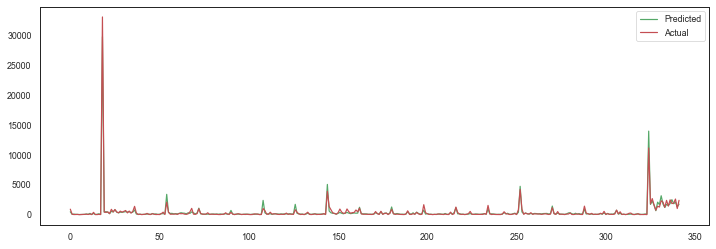

In [73]:
predicted_counts = dd_deptos_ps.prodsimest.values
actual_counts =    dd_deptos_ps.personas_mig.values

fig = plt.figure(figsize=(12, 4))

predicted, = plt.plot(dd_deptos_ps.index, predicted_counts, 'g-', label='Predicted')
actual, = plt.plot(dd_deptos_ps.index, actual_counts, 'r-', label='Actual')
plt.legend(handles=[predicted, actual])
plt.show()

In [74]:
# con train-test split
dd_deptos_ps = cargar_dd_deptos()

mask = np.random.rand(len(dd_deptos_ps)) < 0.8

df_train = dd_deptos_ps[mask]
df_test = dd_deptos_ps[~mask]

In [75]:
df_test.head()

,cod,depto_origen,depto_destino,personas_mig,personas_mig_18_25,personas_mig_26_35,personas_mig_100k,pob_origen,pob_destino,dist,...,tasa_desemp_total_2011_des,log_pbi_destino,log_dist_km,log_pbi_origen_millardos,log_pbi_destino_millardos,log_pob_destino_k,log_pob_origen_k,log_edad_prom_des,log_porc_ocupados_des,largo_limite_km
0,102,1,2,914,114,247,891,1318755,73377,610726,...,8.1,16.469807,6.415097,6.143859,2.654298,4.295611,7.184443,3.525387,4.151677,1.000000e-07
1,302,3,2,74,9,22,70,520173,73377,601915,...,8.1,16.469807,6.400257,4.457899,2.654298,4.295611,6.254161,3.525387,4.151677,1.000000e-07
3,502,5,2,28,7,8,25,123203,73377,556292,...,8.1,16.469807,6.320768,3.779383,2.654298,4.295611,4.813833,3.525387,4.151677,1.000000e-07
7,902,9,2,7,2,1,7,58815,73377,593134,...,8.1,16.469807,6.385194,2.746886,2.654298,4.295611,4.074397,3.525387,4.151677,1.000000e-07
8,1002,10,2,46,11,11,45,164298,73377,658957,...,8.1,16.469807,6.490724,3.937925,2.654298,4.295611,5.101682,3.525387,4.151677,1.000000e-07


In [76]:
formula = "personas_mig ~ nom_depto_orig + log_pbi_destino + log_dist_km -1"
model = smf.glm(formula=formula, data=df_train, family = sm.families.Poisson())
prodSim = model.fit()

# predicción
pred = prodSim.get_prediction(df_test)
pred.summary_frame()['mean'].round(0).astype(int)

0      455
1       75
2       55
3       32
4       51
      ... 
72    1498
73    1577
74    3012
75    1816
76    1311
Name: mean, Length: 77, dtype: int32

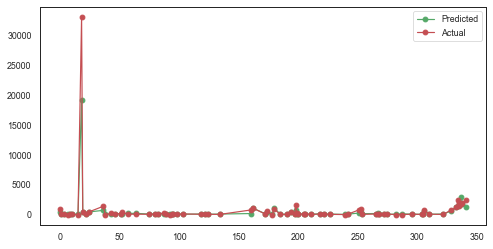

In [77]:
predicted_counts = pred.summary_frame()['mean'].round(0).astype(int)
actual_counts = df_test.personas_mig

fig = plt.figure(figsize=(8, 4))

predicted, = plt.plot(df_test.index, predicted_counts, 'go-', label='Predicted')
actual, = plt.plot(df_test.index, actual_counts, 'ro-', label='Actual')
plt.legend(handles=[predicted, actual])
plt.show()

Text(0, 0.5, 'Groud truth')

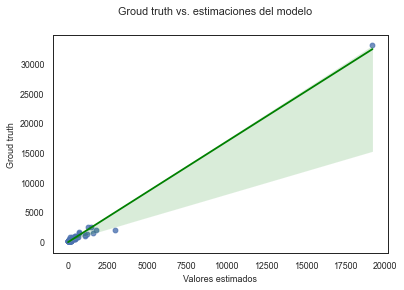

In [78]:
fig = plt.figure()
sns.regplot(x=predicted_counts, y=actual_counts, line_kws={"color": "green"})

fig.suptitle('Groud truth vs. estimaciones del modelo')
plt.xlabel('Valores estimados')
plt.ylabel('Groud truth')

In [79]:
# genera matriz de diferencias
gt_array = matrix.iloc[0:19, 0:19].values
pred_array = matrix_prodsim.iloc[0:19, 0:19].values

delta = abs(gt_array-pred_array).astype(np.double).round(0)
np.fill_diagonal(delta, np.nan)

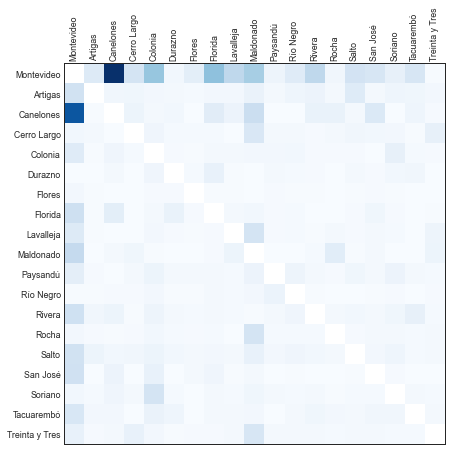

In [80]:
# imprime la matriz de las diferencias
fig = plt.figure(figsize=(7,7))

ax = fig.add_subplot(111)
cax = ax.matshow(delta, cmap='Blues')

nomdep = cargar_nombres()
plt.xticks(np.arange(0, 19, step=1), labels=nomdep, rotation=90)
plt.yticks(np.arange(0, 19, step=1), labels=nomdep)

ax.tick_params(axis=u'both', which=u'both',length=0)

plt.show()

#### **Otro modelo restringido en producción con la *dummy* de límites compartidos como predictor**

**Este modelo es similar al aplicado en R, devolviendo los mismos resultados en ambas plataformas**

In [81]:
# recarga data
dd_deptos_ps = cargar_dd_deptos()
dd_deptos_ps.head(2)

,cod,depto_origen,depto_destino,personas_mig,personas_mig_18_25,personas_mig_26_35,personas_mig_100k,pob_origen,pob_destino,dist,...,tasa_desemp_total_2011_des,log_pbi_destino,log_dist_km,log_pbi_origen_millardos,log_pbi_destino_millardos,log_pob_destino_k,log_pob_origen_k,log_edad_prom_des,log_porc_ocupados_des,largo_limite_km
0,102,1,2,914,114,247,891,1318755,73377,610726,...,8.1,16.469807,6.415097,6.143859,2.654298,4.295611,7.184443,3.525387,4.151677,1.000000e-07
1,302,3,2,74,9,22,70,520173,73377,601915,...,8.1,16.469807,6.400257,4.457899,2.654298,4.295611,6.254161,3.525387,4.151677,1.000000e-07


In [82]:
# define el string tomado como fórmula
formula = "personas_mig ~ nom_depto_orig + dummy_limit + np.log(largo_limite) + log_pbi_destino + pbi_porcen_des + log_dist_km -1"

# entrena y ajusta el modelo
prodSim = smf.glm(formula=formula, data=dd_deptos_ps, family = sm.families.Poisson()).fit()

# resultados
prodSim.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:           personas_mig   No. Observations:                  342
Model:                            GLM   Df Residuals:                      318
Model Family:                 Poisson   Df Model:                           23
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -9047.2
Date:                Tue, 02 Aug 2022   Deviance:                       15866.
Time:                        18:28:49   Pearson chi2:                 1.77e+04
No. Iterations:                     6   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
nom_depto_orig[ARTIGAS]          -11.9523      0.159    -75.000      0.000     -12.265     -11.640
nom_depto_orig[CANELONES]        -11.8383      0.152    -77.836      0.000     -12.136     -11.540
nom_depto_orig[CERRO LARGO]      -12.2134      0.158    -77.317      0.000     -12.523     -11.904
nom_depto_orig[COLONIA]          -12.2019      0.156    -78.280      0.000     -12.507     -11.896
nom_depto_orig[DURAZNO]          -12.5625      0.156    -80.444      0.000     -12.869     -12.256
nom_depto_orig[FLORES]           -13.4113      0.157    -85.170      0.000     -13.720     -13.103
nom_depto_orig[FLORIDA]          -12.7150      0.156    -81.510      0.000     -13.021     -12.409
nom_depto_orig[LAVALLEJA]        -12.8804      0.157    -81.968      0.000     -13.188     -12.572
nom_depto_orig[MALDONADO]        -12.1165      0.156    -77.602      0.000     -12.423     -11.811
nom_depto_orig[MONTEVIDEO]        -9.4952      0.155    -61.348      0.000      -9.799      -9.192
nom_depto_orig[PAYSANDU]         -12.1741      0.157    -77.511      0.000     -12.482     -11.866
nom_depto_orig[RIO NEGRO]        -12.6230      0.157    -80.481      0.000     -12.930     -12.316
nom_depto_orig[RIVERA]           -12.0907      0.159    -76.155      0.000     -12.402     -11.780
nom_depto_orig[ROCHA]            -12.5828      0.158    -79.721      0.000     -12.892     -12.273
nom_depto_orig[SALTO]            -12.0631      0.158    -76.234      0.000     -12.373     -11.753
nom_depto_orig[SAN JOSE]         -12.8166      0.158    -81.003      0.000     -13.127     -12.506
nom_depto_orig[SORIANO]          -12.3126      0.157    -78.643      0.000     -12.619     -12.006
nom_depto_orig[TACUAREMBO]       -12.1512      0.158    -77.015      0.000     -12.460     -11.842
nom_depto_orig[TREINTA Y TRES]   -12.6303      0.157    -80.310      0.000     -12.938     -12.322
dummy_limit[T.True]               -4.9073      0.105    -46.592      0.000      -5.114      -4.701
np.log(largo_limite)               0.2971      0.005     56.292      0.000       0.287       0.307
log_pbi_destino                    1.2132      0.008    156.057      0.000       1.198       1.228
pbi_porcen_des                    -0.0139      0.000    -28.904      0.000      -0.015      -0.013
log_dist_km                       -0.1742      0.007    -25.233      0.000      -0.188      -0.161
==================================================================================================
"""

In [83]:
pred = prodSim.get_prediction(dd_deptos_ps)

dd_deptos_ps['prodsimest'] = pred.summary_frame()['mean'].round(0).astype(int)

print_scores(dd_deptos_ps, 'personas_mig', 'prodsimest', 'restringido en origen')

**Bondad de ajuste del modelo restringido en origen**

$R²$ = 0.9879

RMSE = 213.7413

In [84]:
# guarda
prodSim.save('modelos/restringido_origen__siMVO_v1.pkl')

dd_deptos_ps['prodsimest'].head()
print(dd_deptos_ps.shape)

(342, 47)


In [85]:
# matriz de los valores estimados
pd.pivot_table(dd_deptos_ps,
values='prodsimest',
index ='depto_origen',
columns='depto_destino',
fill_value=0,
aggfunc=sum,
margins=True,
margins_name='Total')

depto_destino,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,Total
depto_origen,,,,,,,,,,,,,,,,,,,,
1,0,744,31581,997,3470,814,412,1324,1081,4408,1722,1575,1171,1114,1547,3409,1528,1085,673,58655
2,2232,0,511,85,243,61,30,85,71,282,152,131,121,82,670,137,119,99,53,5164
3,13273,72,0,97,328,79,40,447,305,983,166,151,113,109,149,606,147,105,66,17236
4,1856,53,428,0,192,172,24,71,63,246,110,96,268,73,104,112,91,268,230,4457
5,2166,50,487,64,0,54,34,79,63,253,123,117,78,69,108,434,456,73,42,4750
6,1474,37,340,168,157,0,76,249,47,180,85,278,58,50,76,92,75,247,68,3757
7,641,16,148,20,85,65,0,73,20,77,39,42,25,21,33,131,126,23,13,1598
8,1422,30,1141,41,136,148,51,0,158,167,71,64,48,44,63,274,61,45,76,4040
9,1149,25,770,36,108,27,13,156,0,628,57,51,40,130,51,67,49,37,94,3488


#### Mismo modelo excluyendo Mvdeo.

In [86]:
# recarga data
dd_deptos_ps = cargar_dd_deptos()

dd_deptos_ps_sin_mvo = dd_deptos_ps.loc[~((dd_deptos_ps.depto_origen==1) | (dd_deptos_ps.depto_destino==1))].reset_index(drop=True).copy()
print(dd_deptos_ps_sin_mvo.shape)
dd_deptos_ps_sin_mvo.head()

(306, 46)


,cod,depto_origen,depto_destino,personas_mig,personas_mig_18_25,personas_mig_26_35,personas_mig_100k,pob_origen,pob_destino,dist,...,tasa_desemp_total_2011_des,log_pbi_destino,log_dist_km,log_pbi_origen_millardos,log_pbi_destino_millardos,log_pob_destino_k,log_pob_origen_k,log_edad_prom_des,log_porc_ocupados_des,largo_limite_km
0,302,3,2,74,9,22,70,520173,73377,601915,...,8.1,16.469807,6.400257,4.457899,2.654298,4.295611,6.254161,3.525387,4.151677,1.000000e-07
1,402,4,2,15,0,6,14,84698,73377,406694,...,8.1,16.469807,6.008813,2.836092,2.654298,4.295611,4.439092,3.525387,4.151677,1.000000e-07
2,502,5,2,28,7,8,25,123203,73377,556292,...,8.1,16.469807,6.320768,3.779383,2.654298,4.295611,4.813833,3.525387,4.151677,1.000000e-07
3,602,6,2,32,0,10,29,57084,73377,446123,...,8.1,16.469807,6.100319,2.566794,2.654298,4.295611,4.044524,3.525387,4.151677,1.000000e-07
4,702,7,2,2,1,1,1,25050,73377,450690,...,8.1,16.469807,6.111467,1.985680,2.654298,4.295611,3.220874,3.525387,4.151677,1.000000e-07


In [87]:
# entrena y ajusta el modelo
prodSim = smf.glm(formula=formula, data=dd_deptos_ps_sin_mvo, family = sm.families.Poisson()).fit()

# guarda el modelo
prodSim.save('modelos/restringido_origen__noMVO_v1.pkl')

# resultados
prodSim.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:           personas_mig   No. Observations:                  306
Model:                            GLM   Df Residuals:                      283
Model Family:                 Poisson   Df Model:                           22
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -5806.1
Date:                Tue, 02 Aug 2022   Deviance:                       9718.5
Time:                        18:28:49   Pearson chi2:                 1.13e+04
No. Iterations:                     6   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
nom_depto_orig[ARTIGAS]           -4.4429      0.469     -9.479      0.000      -5.362      -3.524
nom_depto_orig[CANELONES]         -3.8866      0.469     -8.280      0.000      -4.807      -2.967
nom_depto_orig[CERRO LARGO]       -4.6503      0.467     -9.965      0.000      -5.565      -3.736
nom_depto_orig[COLONIA]           -5.0228      0.468    -10.744      0.000      -5.939      -4.107
nom_depto_orig[DURAZNO]           -5.2091      0.467    -11.164      0.000      -6.124      -4.295
nom_depto_orig[FLORES]            -6.0323      0.468    -12.878      0.000      -6.950      -5.114
nom_depto_orig[FLORIDA]           -5.3595      0.465    -11.515      0.000      -6.272      -4.447
nom_depto_orig[LAVALLEJA]         -5.5040      0.468    -11.764      0.000      -6.421      -4.587
nom_depto_orig[MALDONADO]         -4.5416      0.467     -9.733      0.000      -5.456      -3.627
nom_depto_orig[PAYSANDU]          -4.8396      0.468    -10.350      0.000      -5.756      -3.923
nom_depto_orig[RIO NEGRO]         -5.2418      0.468    -11.207      0.000      -6.158      -4.325
nom_depto_orig[RIVERA]            -4.6451      0.468     -9.929      0.000      -5.562      -3.728
nom_depto_orig[ROCHA]             -5.1170      0.469    -10.921      0.000      -6.035      -4.199
nom_depto_orig[SALTO]             -4.6652      0.468     -9.969      0.000      -5.582      -3.748
nom_depto_orig[SAN JOSE]          -5.2980      0.467    -11.340      0.000      -6.214      -4.382
nom_depto_orig[SORIANO]           -5.0155      0.468    -10.720      0.000      -5.933      -4.099
nom_depto_orig[TACUAREMBO]        -4.7653      0.468    -10.184      0.000      -5.682      -3.848
nom_depto_orig[TREINTA Y TRES]    -5.0172      0.467    -10.741      0.000      -5.933      -4.102
dummy_limit[T.True]              -10.2058      0.235    -43.425      0.000     -10.666      -9.745
np.log(largo_limite)               0.5355      0.012     46.397      0.000       0.513       0.558
log_pbi_destino                    1.0214      0.027     37.220      0.000       0.968       1.075
pbi_porcen_des                     0.0381      0.006      5.897      0.000       0.025       0.051
log_dist_km                       -0.5496      0.016    -34.870      0.000      -0.581      -0.519
==================================================================================================
"""

In [88]:
pred = prodSim.get_prediction(dd_deptos_ps_sin_mvo)

dd_deptos_ps_sin_mvo['prodsimest'] = pred.summary_frame()['mean'].round(0).astype(int)

dd_deptos_ps_sin_mvo.head()

,cod,depto_origen,depto_destino,personas_mig,personas_mig_18_25,personas_mig_26_35,personas_mig_100k,pob_origen,pob_destino,dist,...,log_pbi_destino,log_dist_km,log_pbi_origen_millardos,log_pbi_destino_millardos,log_pob_destino_k,log_pob_origen_k,log_edad_prom_des,log_porc_ocupados_des,largo_limite_km,prodsimest
0,302,3,2,74,9,22,70,520173,73377,601915,...,16.469807,6.400257,4.457899,2.654298,4.295611,6.254161,3.525387,4.151677,1.000000e-07,94
1,402,4,2,15,0,6,14,84698,73377,406694,...,16.469807,6.008813,2.836092,2.654298,4.295611,4.439092,3.525387,4.151677,1.000000e-07,54
2,502,5,2,28,7,8,25,123203,73377,556292,...,16.469807,6.320768,3.779383,2.654298,4.295611,4.813833,3.525387,4.151677,1.000000e-07,32
3,602,6,2,32,0,10,29,57084,73377,446123,...,16.469807,6.100319,2.566794,2.654298,4.295611,4.044524,3.525387,4.151677,1.000000e-07,30
4,702,7,2,2,1,1,1,25050,73377,450690,...,16.469807,6.111467,1.985680,2.654298,4.295611,3.220874,3.525387,4.151677,1.000000e-07,13


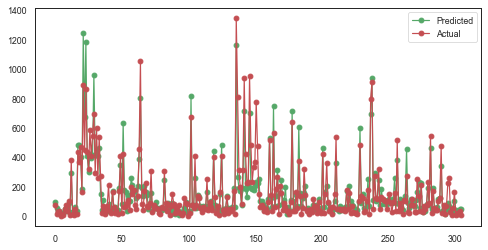

In [89]:
predicted_counts = dd_deptos_ps_sin_mvo.prodsimest
actual_counts = dd_deptos_ps_sin_mvo.personas_mig

fig = plt.figure(figsize=(8, 4))

predicted, = plt.plot(dd_deptos_ps_sin_mvo.index, predicted_counts, 'go-', label='Predicted')
actual, = plt.plot(dd_deptos_ps_sin_mvo.index, actual_counts, 'ro-', label='Actual')
plt.legend(handles=[predicted, actual])
plt.show()

Text(0, 0.5, 'Groud truth')

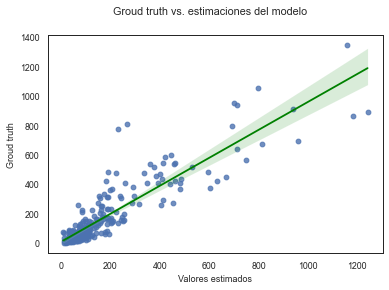

In [90]:
fig = plt.figure()
sns.regplot(x=predicted_counts, y=actual_counts, line_kws={"color": "green"})

fig.suptitle('Groud truth vs. estimaciones del modelo')
plt.xlabel('Valores estimados')
plt.ylabel('Groud truth')

# Modelo de doble restricción

5    $$ T_{ij} = A_{i}O_{i}B_{i}D_{j}d_{ij}^{-\beta }$$

dónde

6 $$O_{i} = \sum_{j}T_{ij}$$

7 $$D_{j} = \sum_{i}T_{ij}$$

8 $$A_{i} = \frac{1}{\sum_{j}B_{j}D_{j}d_{ij}^{-\beta}}$$

9 $$B_{j} = \frac{1}{\sum_{j}A_{i}O_{j}d_{ij}^{-\beta}}$$

La dificultad es que $A_{i}$ depende de $B_{j}$ y viceversa. Pero se puede arrivar a un valor para ambos factores fijando el valor de $B$ inicialmente como 1, y luego iterando refinando el valor de cada uno hasta que sea estable (converjan).

La limitación del modelo de doble restricción es que no se le pueden agregar variables específicas del origen o del destino.

In [91]:
# Modelo de restricción doble

# recupera los datos del respaldo
dd_deptos_dc =  cargar_dd_deptos()

# siguiendo a Dennett y la guía de R, cambiamos la fórmula, borrando el "-1" al final es decir que se mantiene la intersección

# The code below has changed a litte from the singly constrained models I have removed the ‘-1’  which means that an intercept will appear in the model again. This is not because I want an intercept as it makes the origin and destination coefficients harder to interpret - reference categories zones will appear and the coefficients will need to be compared with the intercept - rather the ‘-1’ cheat for removing the intercept only works with one factor level - here we have two (origins and destinations).
# For full details and an explanation for alternative ways for dealing with this, please visit here - https://stats.stackexchange.com/questions/215779/removing-intercept-from-glm-for-multiple-factorial-predictors-only-works-for-fir - for ease, here we will just continue with the intercept.

# con logaritmo de distancia
formula = "personas_mig ~ nom_depto_orig + nom_depto_des + log_dist_km -1"

doubSim = smf.glm(formula=formula, data = dd_deptos_dc, family = sm.families.Poisson()).fit()
doubSim.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:           personas_mig   No. Observations:                  342
Model:                            GLM   Df Residuals:                      304
Model Family:                 Poisson   Df Model:                           37
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -12540.
Date:                Tue, 02 Aug 2022   Deviance:                       22852.
Time:                        18:28:51   Pearson chi2:                 2.47e+04
No. Iterations:                     6   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
nom_depto_orig[ARTIGAS]             9.1440      0.041    223.313      0.000       9.064       9.224
nom_depto_orig[CANELONES]           8.8794      0.032    278.742      0.000       8.817       8.942
nom_depto_orig[CERRO LARGO]         8.7900      0.040    217.777      0.000       8.711       8.869
nom_depto_orig[COLONIA]             8.4956      0.039    218.189      0.000       8.419       8.572
nom_depto_orig[DURAZNO]             8.2453      0.040    208.252      0.000       8.168       8.323
nom_depto_orig[FLORES]              7.3014      0.044    167.684      0.000       7.216       7.387
nom_depto_orig[FLORIDA]             8.0032      0.038    209.527      0.000       7.928       8.078
nom_depto_orig[LAVALLEJA]           7.9650      0.039    204.117      0.000       7.889       8.041
nom_depto_orig[MALDONADO]           8.5795      0.038    226.699      0.000       8.505       8.654
nom_depto_orig[MONTEVIDEO]         10.8526      0.034    323.530      0.000      10.787      10.918
nom_depto_orig[PAYSANDU]            8.8239      0.039    224.393      0.000       8.747       8.901
nom_depto_orig[RIO NEGRO]           8.3217      0.040    206.797      0.000       8.243       8.401
nom_depto_orig[RIVERA]              8.9731      0.040    223.384      0.000       8.894       9.052
nom_depto_orig[ROCHA]               8.3296      0.040    205.677      0.000       8.250       8.409
nom_depto_orig[SALTO]               9.0631      0.040    227.571      0.000       8.985       9.141
nom_depto_orig[SAN JOSE]            7.8940      0.037    211.188      0.000       7.821       7.967
nom_depto_orig[SORIANO]             8.5921      0.039    219.810      0.000       8.516       8.669
nom_depto_orig[TACUAREMBO]          8.9472      0.039    227.401      0.000       8.870       9.024
nom_depto_orig[TREINTA Y TRES]      8.2617      0.041    202.625      0.000       8.182       8.342
nom_depto_des[T.CANELONES]          1.7628      0.026     68.955      0.000       1.713       1.813
nom_depto_des[T.CERRO LARGO]        0.3458      0.030     11.600      0.000       0.287       0.404
nom_depto_des[T.COLONIA]            0.6346      0.027     23.300      0.000       0.581       0.688
nom_depto_des[T.DURAZNO]           -0.1399      0.031     -4.545      0.000      -0.200      -0.080
nom_depto_des[T.FLORES]            -0.9099      0.036    -25.006      0.000      -0.981      -0.839
nom_depto_des[T.FLORIDA]           -0.1323      0.029     -4.484      0.000      -0.190      -0.074
nom_depto_des[T.LAVALLEJA]         -0.2451      0.031     -7.957      0.000      -0.306      -0.185
nom_depto_des[T.MALDONADO]          1.3581      0.025     53.576      0.000       1.308       1.408
nom_depto_des[T.MONTEVIDEO]         2.8777      0.025    116.928      0.000       2

In [92]:
# guarda DF para enviar a Eugenia
#dd_deptos_dc.head()
#dd_deptos_dc.to_csv('tablas/dd_deptos_dc.csv', index=False)

In [93]:
doubSim_latex = doubSim.summary().as_latex()
f = open("tablas/doubSim.tex", "w")
f.write(doubSim_latex)
f.close()

In [94]:
# recupera los valores estimados
dd_deptos_dc['doubsim_ajustado'] = np.round(doubSim.predict())

dd_deptos_dc['depto_origen'] = dd_deptos_dc.depto_origen.astype(int)

# matriz de los valores estimados
matrix_doubsim = pd.pivot_table(dd_deptos_dc,
                                values='doubsim_ajustado',
                                index ='depto_origen',
                                columns='depto_destino',
                                fill_value=0,
                                aggfunc=sum,
                                margins=True,
                                margins_name='Total')

matrix_doubsim.Total = matrix_doubsim.Total.astype(int)

matrix_doubsim

depto_destino,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,Total
depto_origen,,,,,,,,,,,,,,,,,,,,
1,0,517,31717,1001,2411,1005,496,1636,1202,6313,1090,898,955,1266,1116,4028,1029,1135,839,58654
2,1663,0,551,177,189,102,47,90,75,345,226,142,380,120,406,157,125,263,105,5163
3,13443,73,0,145,313,144,71,253,186,938,154,125,135,187,157,480,144,161,123,17232
4,1600,88,548,0,149,101,40,88,93,405,121,84,204,160,156,138,85,188,214,4462
5,2152,52,660,83,0,95,62,97,67,319,136,131,92,86,129,247,174,110,61,4753
6,1515,48,514,95,160,0,70,106,66,273,104,82,93,82,105,149,92,128,76,3758
7,628,18,213,31,87,59,0,40,23,103,51,41,35,29,45,76,49,46,24,1598
8,1921,33,701,65,128,83,37,0,71,295,71,55,62,73,71,180,61,78,56,4041
9,1520,29,556,73,95,55,23,76,0,457,55,42,56,101,57,113,46,64,70,3488


In [95]:
matrix_doubsim_tex = matrix_doubsim.rename(index=deptos_dict)

colformato = format_cols_latex('0.7', 19 )

matrix_doubsim_tex.to_latex(buf = "tablas/doubsim_matriz_orig_dest.tex",
                            bold_rows = False,
                            column_format = colformato,
                            float_format ="%.2f",
                            caption = 'Matriz de movimientos entre departamentos estimada mediante SIM de doble restricción.')

In [96]:
matrix

personas_mig                                                   \
depto_destino            1     2      3     4     5     6     7     8     9   
depto_origen                                                                  
1                        0   914  33127  1387  2100   982   378  1026   825   
2                     2395     0    536    20   167    33    21    40    15   
3                    11162    74      0   274   422   223    82   670   403   
4                     1805    15    435     0    63    67     5    73   131   
5                     2690    28    366    20     0    63    69    53    19   
6                     1610    32    466    64    70     0   149   404    67   
7                      735     2    162    13    86    90     0    76     5   
8                     1420    13    892    37   107   307    84     0   163   
9                     1264     7    446    64    39    29    17   138     0   
10                    2333    46    862   208   196    75    58   121   407   
11                    2096    75    434    35   151    55    29    57    37   
12                    1219    30    316    20   176    54    77    27    15   
13                    2390   102    584   162    77    50    22    63    49   
14                    1435     8    407    59    49    18     7    45   130   
15                    2481   380    543    18   134    14    20    48    20   
16                    1852    15    689    31   452    59   122   252    44   
17                    1922     9    293    12  1053    57    90    40    33   
18                    2611    50    596   168    79   304    79    92    50   
19                    1024    10    259   409    41    91     2    58   172   
Total                42444  1810  41413  3001  5462  2571  1311  3283  2585   

                                                                            \
depto_destino     10    11    12    13    14    15    16    17    18    19   
depto_origen                                                                 
1               3914  1075   886  1665  1266  1547  4209  1173  1421   760   
2                472   200    57   146    47   794    92    24   100     5   
3               1345   148   154   320   360   159   908   154   251   124   
4                810    61    41   145    95    19    49    34   135   476   
5                309    71    88    34    35    68   269   513    34    23   
6                198    59    62    42    61    28   124    32   212    77   
7                 79    30    36    10    13    17   116    85    29    14   
8                310    47    30    46    62    19   321    51    68    64   
9                936    28    11    25   150    15    45    11    45   221   
10                 0    95    95   117   535    98   131   110    71   259   
11               420     0   640    66    50   480   116    98   229    25   
12               223   516     0    54    48   133   107   270    89     9   
13               227   143    36     0    46   120    99    25   546    57   
14               952    32    30    17     0    29    45    18    21   162   
15               484   564   161    97    38     0    99    75   166     8   
16               230    59    55    32    47    30     0   112    53    23   
17               335   181   372    18    46    98   147     0    41    16   
18               363   261   134   421    35   174    88    72     0    32   
19               776    16    16    23   174    13    28    25    38     0   
Total          12383  3586  2904  3278  3108  3841  6993  2882  3549  2355   

                       
depto_destino   Total  
depto_origen           
1               58655  
2                5164  
3               17233  
4                4459  
5                4752  
6                3757  
7                1598  
8                4041  
9                3491  
10               5817  
11               5093  
12               3383  
13               4798  
14               

Se puede observar la igualdad de los valores originales $O_{i}$ y $D_{j}$, pero al igual que en el modelo de restricción en origen se producen leves direrencias que atrubuimos al redondeo.

In [97]:
printmd('**Bondad de ajuste del modelo de doble restricción**')

r2 = r2_score(dd_deptos_dc['personas_mig'], dd_deptos_dc['doubsim_ajustado'])

rmse = mean_squared_error(dd_deptos_dc['personas_mig'], dd_deptos_dc['doubsim_ajustado'], squared=False)

printmd("$R²$ = " + round(r2, 4).astype(str))

printmd("RMSE = " + round(rmse, 4).astype(str))

**Bondad de ajuste del modelo de doble restricción**

$R²$ = 0.9826

RMSE = 256.8742

El coeficiente de determinación $R²$ mejora en comparación con resultante del modelo restringido en origen.

In [98]:
# sin logaritmo
# modelo exponencial
formula = "personas_mig ~ nom_depto_orig + nom_depto_des + dist -1"

doubSim_exp = smf.glm(formula=formula, data= dd_deptos_dc, family = sm.families.Poisson()).fit()
doubSim_exp.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:           personas_mig   No. Observations:                  342
Model:                            GLM   Df Residuals:                      304
Model Family:                 Poisson   Df Model:                           37
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -15433.
Date:                Tue, 02 Aug 2022   Deviance:                       28639.
Time:                        18:28:52   Pearson chi2:                 3.39e+04
No. Iterations:                     6   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
nom_depto_orig[ARTIGAS]             6.6270      0.031    214.874      0.000       6.567       6.687
nom_depto_orig[CANELONES]           6.5591      0.026    256.928      0.000       6.509       6.609
nom_depto_orig[CERRO LARGO]         5.9880      0.030    198.511      0.000       5.929       6.047
nom_depto_orig[COLONIA]             5.5081      0.029    189.929      0.000       5.451       5.565
nom_depto_orig[DURAZNO]             5.2525      0.030    175.713      0.000       5.194       5.311
nom_depto_orig[FLORES]              4.3281      0.035    122.600      0.000       4.259       4.397
nom_depto_orig[FLORIDA]             5.0774      0.029    173.747      0.000       5.020       5.135
nom_depto_orig[LAVALLEJA]           5.0205      0.030    167.280      0.000       4.962       5.079
nom_depto_orig[MALDONADO]           5.6100      0.028    199.628      0.000       5.555       5.665
nom_depto_orig[MONTEVIDEO]          8.3102      0.025    331.862      0.000       8.261       8.359
nom_depto_orig[PAYSANDU]            5.9972      0.029    205.608      0.000       5.940       6.054
nom_depto_orig[RIO NEGRO]           5.4613      0.031    177.590      0.000       5.401       5.522
nom_depto_orig[RIVERA]              6.2982      0.030    213.490      0.000       6.240       6.356
nom_depto_orig[ROCHA]               5.3934      0.031    175.648      0.000       5.333       5.454
nom_depto_orig[SALTO]               6.3769      0.029    218.985      0.000       6.320       6.434
nom_depto_orig[SAN JOSE]            5.0621      0.029    174.428      0.000       5.005       5.119
nom_depto_orig[SORIANO]             5.6685      0.029    194.137      0.000       5.611       5.726
nom_depto_orig[TACUAREMBO]          6.0769      0.029    211.033      0.000       6.020       6.133
nom_depto_orig[TREINTA Y TRES]      5.3430      0.031    171.710      0.000       5.282       5.404
nom_depto_des[T.CANELONES]          2.0265      0.025     81.562      0.000       1.978       2.075
nom_depto_des[T.CERRO LARGO]        0.1635      0.030      5.471      0.000       0.105       0.222
nom_depto_des[T.COLONIA]            0.3007      0.027     10.972      0.000       0.247       0.354
nom_depto_des[T.DURAZNO]           -0.4909      0.031    -15.878      0.000      -0.551      -0.430
nom_depto_des[T.FLORES]            -1.2373      0.036    -33.900      0.000      -1.309      -1.166
nom_depto_des[T.FLORIDA]           -0.4276      0.030    -14.403      0.000      -0.486      -0.369
nom_depto_des[T.LAVALLEJA]         -0.5543      0.031    -17.889      0.000      -0.615      -0.494
nom_depto_des[T.MALDONADO]          1.0512      0.026     41.079      0.000       1.001       1.101
nom_depto_des[T.MONTEVIDEO]         2.9059      0.024    118.621      0.000       2

In [99]:
# Get the estimates
dd_deptos_dc['doubsimfitted_exp'] = np.round(doubSim_exp.predict())

# Here's the matrix
pd.pivot_table(dd_deptos_dc,
values='doubsimfitted_exp',
index ='depto_origen',
columns='depto_destino',
fill_value=0,
aggfunc=sum,
margins=True,
margins_name='Total')


printmd('**Bondad de ajuste del modelo de doble restricción**')
r2 = r2_score(dd_deptos_dc['personas_mig'], dd_deptos_dc['doubsimfitted_exp'])

rmse = mean_squared_error(dd_deptos_dc['personas_mig'], dd_deptos_dc['doubsimfitted_exp'], squared=False)

printmd("$R²$ = " + round(r2, 4).astype(str))

printmd("RMSE = " + round(rmse, 4).astype(str))

**Bondad de ajuste del modelo de doble restricción**

$R²$ = 0.9628

RMSE = 375.3346

### Versión iterativa para calcular los factores de balance

Se toma la siguiente función, desarrollada por XXX basado en Dennet.
Los inputs son:

- df: un dataframe de pandas con los flújos diádicos

- orig_field: nombre del campo con las etiquetas de los origenes

- dest_field: nombre del campo con las etiquetas de los destinos

- Oi_field: nombre del campo con los flujos totales dado un origen $i$

- Dj_field: nombre del campo con los flujos totales dado a un destino $j$

- cij_field: nombre del campo con los costos diádicos (ej.: distancia) entre $i$ y $j$

- beta: constante

- cost_function: un texto que identifica la función de costo ('power' o 'exponential')

- Ainame: nombre del nuevo campo en el cual se guardarán los valores $A_{i}$, con valores por defecto "Ai_new"

- Bjname: nombre del nuevo campo en el cual se guardarán los valores $B_{j}$, con valores por defecto "Bj_new"

- converge: un umbral llegado al cual podemos afirmar que el modelo convergió, por defecto es 0.001


$O_{i}$ and $D_{j}$ son los totales de flujos por origen o destino, calculados previamente.

La función representa el abordaje maximizador de la entropía para un beta conocido.

fuente: https://github.com/danlewis85/UCL_CASA_Urban_Simulation/blob/master/Constrained%20SIM.ipynb

In [100]:
dd_deptos_dc.head()

,cod,depto_origen,depto_destino,personas_mig,personas_mig_18_25,personas_mig_26_35,personas_mig_100k,pob_origen,pob_destino,dist,...,log_dist_km,log_pbi_origen_millardos,log_pbi_destino_millardos,log_pob_destino_k,log_pob_origen_k,log_edad_prom_des,log_porc_ocupados_des,largo_limite_km,doubsim_ajustado,doubsimfitted_exp
0,102,1,2,914,114,247,891,1318755,73377,610726,...,6.415097,6.143859,2.654298,4.295611,7.184443,3.525387,4.151677,1.000000e-07,517.0,422.0
1,302,3,2,74,9,22,70,520173,73377,601915,...,6.400257,4.457899,2.654298,4.295611,6.254161,3.525387,4.151677,1.000000e-07,73.0,76.0
2,402,4,2,15,0,6,14,84698,73377,406694,...,6.008813,2.836092,2.654298,4.295611,4.439092,3.525387,4.151677,1.000000e-07,88.0,88.0
3,502,5,2,28,7,8,25,123203,73377,556292,...,6.320768,3.779383,2.654298,4.295611,4.813833,3.525387,4.151677,1.000000e-07,52.0,31.0
4,602,6,2,32,0,10,29,57084,73377,446123,...,6.100319,2.566794,2.654298,4.295611,4.044524,3.525387,4.151677,1.000000e-07,48.0,37.0


In [101]:
# basado en: https://journals.sagepub.com/doi/abs/10.1177/030913257900300218
# Here is the entropy maximising approach for a known beta.
# Plug in the required values in this function to solve.

def balance_doubly_constrained(df, orig_field, dest_field,
                               Oi_field, Dj_field, cij_field, beta, 
                               cost_function,
                               Ai_name = "Ai_new", Bj_name = "Bj_new", converge=0.001):
    # Define some variables
    Oi = df[[orig_field, Oi_field]]
    Dj = df[[dest_field,Dj_field]]
    
    if cost_function.lower() in ['power','pow']:
        beta_cij = np.exp(beta * np.log(df[cij_field]))
    elif cost_function.lower() in ['exponential','exp']:
        beta_cij = np.exp(beta * df[cij_field])
    else:
        return "Cost function not specified properly, use 'exp' or 'pow'"
    
    # Create some helper variables
    cnvg = 1
    iteration = 0
    
    # Now iteratively rebalance the Ai and Bj terms until convergence
    while cnvg > converge:
        if iteration == 0:
            # This first condition sets starting values for Ai and Bj
            # NB sets starting value of Ai assuming Bj is a vector of 1s.
            # We've already established beta_cij with the appropriate cost function, so...
            Oi = Oi.assign(Ai = Dj[Dj_field] * beta_cij)
            # Aggregate Ai and take inverse
            Ai = 1.0/Oi.groupby(orig_field)['Ai'].sum().to_frame()
            # Merge new Ais 
            Oi = Oi.merge(Ai,left_on = orig_field, right_index = True, suffixes = ('','_old'))
            # Drop the temporary Ai field we created, leaving Ai_old
            Oi.drop('Ai', axis=1, inplace=True)
            
            # Now set up Bjs using starting values of Ai
            Dj = Dj.assign(Bj = Oi['Ai_old'] * Oi[Oi_field] * beta_cij)
            # Aggregate Bj and take inverse
            Bj = 1.0/Dj.groupby(dest_field)['Bj'].sum().to_frame()
            # Merge new Bjs
            Dj = Dj.merge(Bj,left_on = dest_field, right_index = True, suffixes = ('','_old'))
            # Drop the temporary Bj field we created, leaving Bj_old
            Dj.drop('Bj', axis=1, inplace=True)
            
            # Increment loop
            iteration += 1
        else:
            # This bit is the iterated bit of the loop which refines the values of Ai and Bj
            # First Ai
            Oi['Ai'] = Dj['Bj_old'] * Dj[Dj_field] * beta_cij
            # Aggregate Ai and take inverse
            Ai = 1.0/Oi.groupby(orig_field)['Ai'].sum().to_frame()
            # Drop temporary Ai
            Oi.drop('Ai', axis=1, inplace=True)
            # Merge new Ais 
            Oi = Oi.merge(Ai,left_on = orig_field, right_index = True)
            # Calculate the difference between old and new Ais
            Oi['diff'] = np.absolute((Oi['Ai_old'] - Oi['Ai'])/Oi['Ai_old'])
            # Set new Ais to Ai_old
            Oi['Ai_old'] = Oi['Ai']
            # Drop the temporary Ai field we created, leaving Ai_old
            Oi.drop('Ai', axis=1, inplace=True)
            
            # Then Bj
            Dj['Bj'] = Oi['Ai_old'] * Oi[Oi_field] * beta_cij
            # Aggregate Bj and take inverse
            Bj = 1.0/Dj.groupby(dest_field)['Bj'].sum().to_frame()
            # Drop temporary Bj
            Dj.drop('Bj', axis=1, inplace=True)
            # Merge new Bjs
            Dj = Dj.merge(Bj,left_on = dest_field, right_index = True)
            # Calculate the difference between old and new Bjs
            Dj['diff'] = np.absolute((Dj['Bj_old'] - Dj['Bj'])/Dj['Bj_old'])
            # Set new Bjs to Bj_old
            Dj['Bj_old'] = Dj['Bj']
            # Drop the temporary Bj field we created, leaving Bj_old
            Dj.drop('Bj', axis=1, inplace=True)
            
            # Assign higher sum difference from Ai or Bj to cnvg
            cnvg = np.maximum(Oi['diff'].sum(),Dj['diff'].sum())
            
            # Print and increment loop
            print("Iteration:", iteration)
            iteration += 1

    # When the while loop finishes add the computed Ai_old and Bj_old to the dataframe and return
    df[Ai_name] = Oi['Ai_old']
    df[Bj_name] = Dj['Bj_old']
    return df

In [102]:
# create some Oi and Dj columns in the dataframe and store row and column totals in them:
# First get the origin sums and rename the column created
O_i = dd_deptos_dc.groupby('depto_origen')['personas_mig'].sum().to_frame()
O_i.rename(columns = {'personas_mig':'O_i'}, inplace=True)

# Now get the destination sums
D_j = dd_deptos_dc.groupby('depto_destino')['personas_mig'].sum().to_frame()
D_j.rename(columns = {'personas_mig':'D_j'}, inplace=True)

# Merge in O_i
dd_deptos_dc = dd_deptos_dc.merge(O_i,left_on='depto_origen', right_index=True)

# Merge in D_j
dd_deptos_dc = dd_deptos_dc.merge(D_j,left_on='depto_destino', right_index=True)

dd_deptos_dc.head()

,cod,depto_origen,depto_destino,personas_mig,personas_mig_18_25,personas_mig_26_35,personas_mig_100k,pob_origen,pob_destino,dist,...,log_pbi_destino_millardos,log_pob_destino_k,log_pob_origen_k,log_edad_prom_des,log_porc_ocupados_des,largo_limite_km,doubsim_ajustado,doubsimfitted_exp,O_i,D_j
0,102,1,2,914,114,247,891,1318755,73377,610726,...,2.654298,4.295611,7.184443,3.525387,4.151677,1.000000e-07,517.0,422.0,58655,1810
1,302,3,2,74,9,22,70,520173,73377,601915,...,2.654298,4.295611,6.254161,3.525387,4.151677,1.000000e-07,73.0,76.0,17233,1810
2,402,4,2,15,0,6,14,84698,73377,406694,...,2.654298,4.295611,4.439092,3.525387,4.151677,1.000000e-07,88.0,88.0,4459,1810
3,502,5,2,28,7,8,25,123203,73377,556292,...,2.654298,4.295611,4.813833,3.525387,4.151677,1.000000e-07,52.0,31.0,4752,1810
4,602,6,2,32,0,10,29,57084,73377,446123,...,2.654298,4.295611,4.044524,3.525387,4.151677,1.000000e-07,48.0,37.0,3757,1810


In [103]:
# recupera el beta del logaritmo de la distancia del modelo anterior
beta_doubSim = doubSim.params[-1]

# recupera factores de balance, con distancias como función de potencia
dd_deptos_dc = balance_doubly_constrained(dd_deptos_dc,
'nom_depto_orig',
'nom_depto_des',
'O_i',
'D_j',
'dist',
beta_doubSim,
'power',
Ai_name = "Ai_new",
Bj_name = "Bj_new",
converge=0.0001)

Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15
Iteration: 16


In [104]:
dd_deptos_dc.head()

,cod,depto_origen,depto_destino,personas_mig,personas_mig_18_25,personas_mig_26_35,personas_mig_100k,pob_origen,pob_destino,dist,...,log_pob_origen_k,log_edad_prom_des,log_porc_ocupados_des,largo_limite_km,doubsim_ajustado,doubsimfitted_exp,O_i,D_j,Ai_new,Bj_new
0,102,1,2,914,114,247,891,1318755,73377,610726,...,7.184443,3.525387,4.151677,1.000000e-07,517.0,422.0,58655,1810,0.033478,2.063613
1,302,3,2,74,9,22,70,520173,73377,601915,...,6.254161,3.525387,4.151677,1.000000e-07,73.0,76.0,17233,1810,0.015743,2.063613
2,402,4,2,15,0,6,14,84698,73377,406694,...,4.439092,3.525387,4.151677,1.000000e-07,88.0,88.0,4459,1810,0.056264,2.063613
3,502,5,2,28,7,8,25,123203,73377,556292,...,4.813833,3.525387,4.151677,1.000000e-07,52.0,31.0,4752,1810,0.039344,2.063613
4,602,6,2,32,0,10,29,57084,73377,446123,...,4.044524,3.525387,4.151677,1.000000e-07,48.0,37.0,3757,1810,0.038738,2.063613


In [105]:
# Now predict the model again using the new Ai and Dj fields.
#####################################################################
# es correcto tomar el logaritmo del logaritmo de la distancia???? ##
#####################################################################
def simest(df):
    val = df['O_i'] * df['Ai_new'] * df['D_j'] * df['Bj_new'] * np.exp(np.log(df['dist'])*beta_doubSim)
    return round(val)

dd_deptos_dc['SIM_est_pow'] = simest(dd_deptos_dc)

# np.exp no es la potencia, sino la función exponencial (e a la x)
dd_deptos_dc[['personas_mig', 'doubsim_ajustado', 'SIM_est_pow']].head(10)

,personas_mig,doubsim_ajustado,SIM_est_pow
0,914,517.0,515.0
1,74,73.0,72.0
2,15,88.0,88.0
3,28,52.0,52.0
4,32,48.0,48.0
5,2,18.0,18.0
6,13,33.0,33.0
7,7,29.0,30.0
8,46,50.0,51.0
9,75,112.0,112.0


In [106]:
# Check out the matrix
pd.pivot_table(dd_deptos_dc,
values='SIM_est_pow',
index ='depto_origen',
columns='depto_destino',
fill_value=0,
aggfunc=sum,
margins=True)

depto_destino,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,All
depto_origen,,,,,,,,,,,,,,,,,,,,
1,0,515,31783,998,2407,1003,495,1633,1198,6300,1086,895,952,1263,1112,4020,1026,1133,836,58655.0
2,1661,0,547,177,189,102,47,91,75,346,226,142,381,120,406,157,125,264,105,5161.0
3,13475,72,0,144,311,143,71,251,185,929,152,124,133,185,156,478,142,159,123,17233.0
4,1598,88,544,0,149,101,40,89,93,406,121,84,204,160,156,138,85,188,214,4458.0
5,2151,52,655,83,0,95,62,98,67,321,136,131,92,87,129,247,174,110,62,4752.0
6,1514,48,510,95,161,0,70,107,66,274,104,82,93,83,105,150,92,128,76,3758.0
7,627,18,211,32,88,59,0,41,23,104,51,41,35,29,45,76,49,46,24,1599.0
8,1920,33,696,65,129,83,38,0,71,297,71,55,63,73,71,180,61,78,56,4040.0
9,1517,30,554,74,95,55,23,77,0,459,55,42,56,101,58,114,46,64,71,3491.0


In [107]:
dd_deptos_dc[['personas_mig', 'doubsim_ajustado', 'SIM_est_pow']].head(10)

,personas_mig,doubsim_ajustado,SIM_est_pow
0,914,517.0,515.0
1,74,73.0,72.0
2,15,88.0,88.0
3,28,52.0,52.0
4,32,48.0,48.0
5,2,18.0,18.0
6,13,33.0,33.0
7,7,29.0,30.0
8,46,50.0,51.0
9,75,112.0,112.0


In [108]:
printmd('**Bondad de ajuste del modelo de doble restricción**')

r2 = r2_score(dd_deptos_dc['personas_mig'], dd_deptos_dc['SIM_est_pow'])

rmse = mean_squared_error(dd_deptos_dc['personas_mig'], dd_deptos_dc['SIM_est_pow'], squared=False)

printmd("$R²$ = " + round(r2, 4).astype(str))

printmd("RMSE = " + round(rmse, 4).astype(str))

**Bondad de ajuste del modelo de doble restricción**

$R²$ = 0.9827

RMSE = 256.42

In [109]:
beta_doubSim_exp = doubSim_exp.params[-1]

# recupera factores de balance
dd_deptos_dc = balance_doubly_constrained(dd_deptos_dc,
'nom_depto_orig',
'nom_depto_des',
'O_i',
'D_j',
'dist',
beta_doubSim_exp,
'exponential',
Ai_name = "Ai_exp",
Bj_name = "Bj_exp",
converge=0.0001)

# Use the beta we got from the negative exponential model
# Now predict the model again using the new Ai and Dj fields.
dd_deptos_dc['SIM_est_exp'] = np.round(dd_deptos_dc['O_i'] * dd_deptos_dc['Ai_exp'] * dd_deptos_dc['D_j'] * dd_deptos_dc['Bj_exp'] * 
                                   np.exp(dd_deptos_dc['dist']*beta_doubSim_exp))

Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13


In [110]:
# atento a la comparación
dd_deptos_dc[['personas_mig', 'doubsim_ajustado', 'SIM_est_pow', 'doubsimfitted_exp', 'SIM_est_exp']].head(10)

,personas_mig,doubsim_ajustado,SIM_est_pow,doubsimfitted_exp,SIM_est_exp
0,914,517.0,515.0,422.0,422.0
1,74,73.0,72.0,76.0,76.0
2,15,88.0,88.0,88.0,88.0
3,28,52.0,52.0,31.0,31.0
4,32,48.0,48.0,37.0,37.0
5,2,18.0,18.0,14.0,14.0
6,13,33.0,33.0,22.0,22.0
7,7,29.0,30.0,17.0,17.0
8,46,50.0,51.0,24.0,24.0
9,75,112.0,112.0,130.0,130.0


In [111]:
# diferencia de 1
dd_deptos_dc.loc[dd_deptos_dc.doubsim_ajustado - dd_deptos_dc.SIM_est_pow > 0, ['doubsim_ajustado', 'SIM_est_pow']]

,doubsim_ajustado,SIM_est_pow
0,517.0,515.0
1,73.0,72.0
19,548.0,544.0
20,660.0,655.0
21,514.0,510.0
...,...,...
337,2329.0,2327.0
338,1784.0,1782.0
339,1997.0,1995.0
340,1181.0,1179.0


In [112]:
# diferencia de 1
dd_deptos_dc.loc[dd_deptos_dc.doubsimfitted_exp - dd_deptos_dc.SIM_est_exp > 0, ['doubsimfitted_exp', 'SIM_est_exp']]

,doubsimfitted_exp,SIM_est_exp


In [113]:
# jugar con modelación de distance decay
# jugar con distancia en lugar de logaritmo
# probar con algún modelo kitchen sink
# graficas y algún mapa
#!jupyter nbconvert --to markdown --no-input 02-metodologia.ipynb 

# graficar logaritmo de los flujos vs logaritmo de la distancia

# probar paquete SPInt taylor oshan

# ATENCIÓN!
# Another thing to note is that the example we used here had quite neat data. You will almost certainly run into problems if you have sparse data or predictors with 0s in them. If this happens, then you might need to either drop some rows in your data (if populated with 0s) or substitute 0s for very small numbers, much less than 1, but greater than 0 (this is because you can’t take the log of 0). Taylor Oshan's SpInt implementation in Python uses a special Poisson regression approach that better handles sparse data structures.
# And another thing to note is that our flow data and our predictors were all in and around the same order or magnitude. If you suddenly get data that (such as population masses at origins and destinations) that are an order of magnitude different (i.e. populations about ten times larger in different locations) then the model estimates might be biased.